Using device: cpu
L shape: torch.Size([10000, 10000])


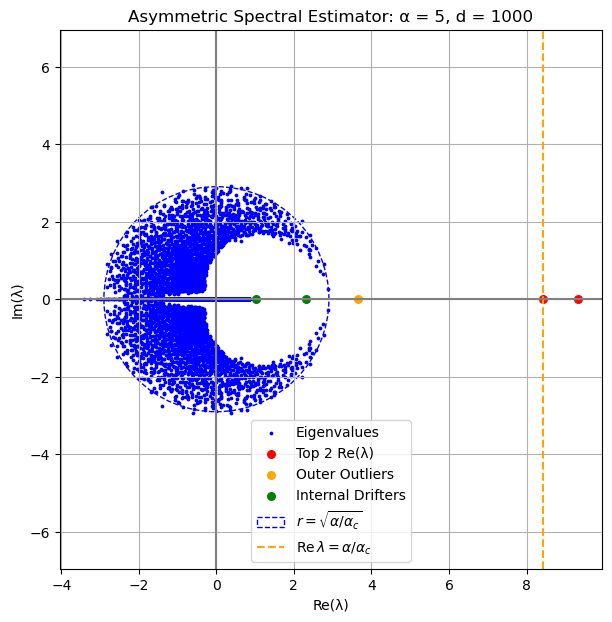


[Single Eigenvector Alignment Scores]
      Type                   λ  Alignment Score
0   Green1  2.314830+0.000000j         0.035650
1   Green2  1.017331+0.000000j         0.399661
2  Orange1  3.663436+0.000000j         0.054449
3     Red1  9.317551+0.000000j         0.616721
4     Red2  8.425322+0.000000j         0.622219

[Eigenvector Pair Subspace Alignment Scores]
             Pair                  λ1                  λ2  Alignment Score
9       Red1-Red2  9.317551+0.000000j  8.425322+0.000000j         0.616721
4  Green2-Orange1  1.017331+0.000000j  3.663436+0.000000j         0.399661
5     Green2-Red1  1.017331+0.000000j  9.317551+0.000000j         0.399661
6     Green2-Red2  1.017331+0.000000j  8.425322+0.000000j         0.399661
7    Orange1-Red1  3.663436+0.000000j  9.317551+0.000000j         0.054449
8    Orange1-Red2  3.663436+0.000000j  8.425322+0.000000j         0.054449
0   Green1-Green2  2.314830+0.000000j  1.017331+0.000000j         0.035650
1  Green1-Orange1  2.314830

/var/folders/kl/6hy0lk_14w14xqln8byr8l940000gn/T/ipykernel_21749/368383425.py:178: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


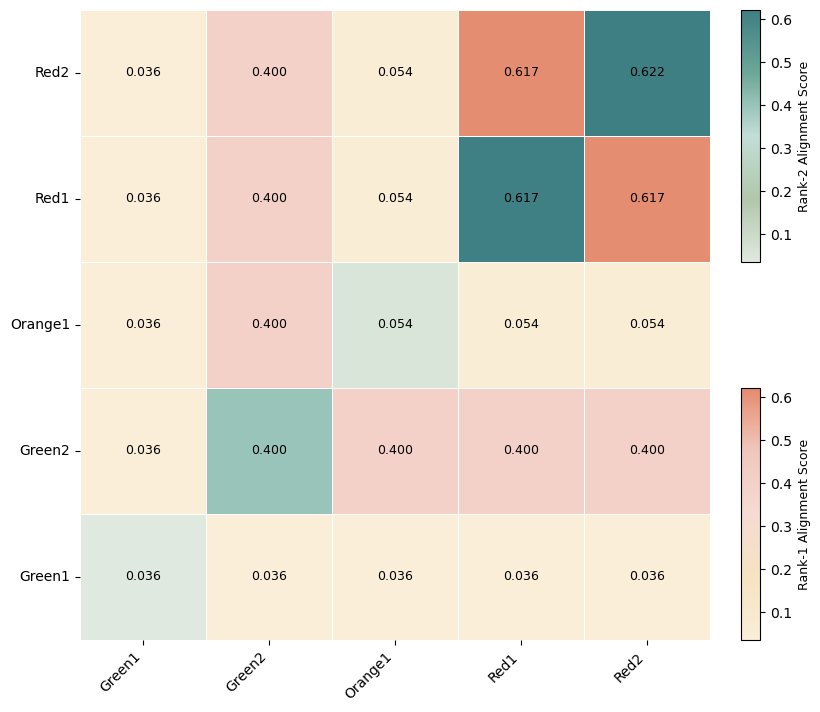

In [7]:
# asymmetric_spectral_estimator.py

import os
import random
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import kv as besselk
from scipy.linalg import qr
from numpy.linalg import norm
from itertools import combinations
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ====================== 设置随机种子与设备 ======================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ====================== 参数设置与数据生成 ======================
n, p = 5000, 2
alpha = 5
alpha_c = 0.59375
d = int(n / alpha)
X = torch.randn(n, d, device=device) / np.sqrt(d)
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
y = Z[:, 0] * Z[:, 1]

# ====================== 构造 G(y) 与谱矩阵 L ======================
y_np = y.detach().cpu().numpy()
abs_y = np.abs(y_np)
K0, K1 = besselk(0, abs_y), besselk(1, abs_y)
lambda_y = abs_y * (K1 / (K0 + 1e-6)) - 1
lambda_y[np.isnan(lambda_y)] = 0

G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_np
G_y_np[:, 1, 0] = y_np
G_y = torch.tensor(G_y_np, device=device)

XXT = X @ X.T
XXT.fill_diagonal_(0.0)
L_blocks = XXT[:, :, None, None] * G_y[None, :, :, :]
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)
print(f"L shape: {L.shape}")

# ====================== 特征值与特征向量计算 ======================
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
eigvals_real_only = [z for z in eigvals_np if np.isclose(z.imag, 0.0, atol=1e-6)]

# ====================== 特征值分类 ======================
R = np.sqrt(alpha / alpha_c)
thresh = alpha / alpha_c

outside = [z for z in eigvals_real_only if abs(z) > R and z.real > 0]
red_vals = sorted(outside, key=lambda z: z.real, reverse=True)[:2]
orange_vals = [z for z in outside if z not in red_vals]
green_candidates = [z for z in eigvals_real_only if abs(z) <= R]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:2]

green_labels = [(f"Green{i+1}", z) for i, z in enumerate(green_vals)]
orange_labels = [(f"Orange{i+1}", z) for i, z in enumerate(orange_vals)]
red_labels = [(f"Red{i+1}", z) for i, z in enumerate(red_vals)]
all_labels = green_labels + orange_labels + red_labels
label_order = [label for label, _ in all_labels]

# ====================== 谱图绘制 ======================
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, s=3, color='blue', label='Eigenvalues')
plt.scatter([z.real for _, z in red_labels], [z.imag for _, z in red_labels], color='red', s=30, label="Top 2 Re(λ)")
plt.scatter([z.real for _, z in orange_labels], [z.imag for _, z in orange_labels], color='orange', s=30, label="Outer Outliers")
plt.scatter([z.real for _, z in green_labels], [z.imag for _, z in green_labels], color='green', s=30, label="Internal Drifters")
circle = plt.Circle((0, 0), R, color='blue', fill=False, linestyle='--', label=rf'$r = \sqrt{{\alpha / \alpha_c}}$')
plt.gca().add_artist(circle)
plt.axvline(x=thresh, color='orange', linestyle='--', label=rf'$\mathrm{{Re}}\,\lambda = \alpha / \alpha_c$')
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# ====================== 子空间恢复函数定义 ======================
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    return np.mean(np.linalg.svd(Q1.T @ Q2)[1])

def extract_W_from_eigenvectors(eigvecs_np, eigval_target, X, W_star, p=2, label=""):
    idx = np.argmin(np.abs(eigvals_np - eigval_target))
    V = eigvecs_np[:, idx].reshape(-1, p)
    U = X.cpu().numpy().T @ V
    W_hat = U / norm(U, axis=0, keepdims=True)
    return (label, eigval_target, alignment_score(W_hat, W_star.cpu().numpy()))

def extract_W_from_eigpair(eigvecs_np, eigvals_np, pair, X, W_star, p=2, label=""):
    idx1 = np.argmin(np.abs(eigvals_np - pair[0]))
    idx2 = np.argmin(np.abs(eigvals_np - pair[1]))
    V1, V2 = eigvecs_np[:, idx1].reshape(-1, p), eigvecs_np[:, idx2].reshape(-1, p)
    V = np.hstack([V1, V2])
    U = X.cpu().numpy().T @ V
    W_hat = U[:, :p] / norm(U[:, :p], axis=0, keepdims=True)
    return (label, pair[0], pair[1], alignment_score(W_hat, W_star.cpu().numpy()))

# ====================== 对齐得分计算 ======================
results_single = [extract_W_from_eigenvectors(eigvecs_np, z, X, W_star, p=2, label=label) for label, z in all_labels]
df_single = pd.DataFrame(results_single, columns=["Type", "λ", "Alignment Score"])
print("\n[Single Eigenvector Alignment Scores]")
print(df_single)

results_pair = []
for (l1, z1), (l2, z2) in combinations(all_labels, 2):
    results_pair.append(extract_W_from_eigpair(eigvecs_np, eigvals_np, (z1, z2), X, W_star, p=2, label=f"{l1}-{l2}"))
df_pair = pd.DataFrame(results_pair, columns=["Pair", "λ1", "λ2", "Alignment Score"])
print("\n[Eigenvector Pair Subspace Alignment Scores]")
print(df_pair.sort_values(by="Alignment Score", ascending=False))

# ====================== 热力图绘制 ======================
heatmap_df = pd.DataFrame(np.nan, index=label_order, columns=label_order)
for _, row in df_single.iterrows():
    heatmap_df.loc[row["Type"], row["Type"]] = row["Alignment Score"]
for _, row in df_pair.iterrows():
    a, b = row["Pair"].split("-")
    heatmap_df.loc[a, b] = heatmap_df.loc[b, a] = row["Alignment Score"]

diag_colors = ["#FAEED9", "#F5E3C2", "#F5DBD4", "#F0C7BC", "#E58B6E"]
offdiag_colors = ["#DFE9DF", "#B2C6AB", "#C2DED7", "#6DA798", "#3E7F84"]
diag_cmap = LinearSegmentedColormap.from_list("diag_cmap", diag_colors)
offdiag_cmap = LinearSegmentedColormap.from_list("offdiag_cmap", offdiag_colors)
mask_diag = pd.DataFrame(True, index=label_order, columns=label_order)
np.fill_diagonal(mask_diag.values, False)

fig, ax = plt.subplots(figsize=(8, 7))
vmin, vmax = np.nanmin(heatmap_df.values), np.nanmax(heatmap_df.values)
sns.heatmap(heatmap_df, mask=mask_diag, cmap=offdiag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)
cbar_ax1 = inset_axes(ax, width="3%", height="40%", loc='upper right',
                      bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
fig.colorbar(plt.cm.ScalarMappable(cmap=offdiag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax)),
             cax=cbar_ax1).set_label("Rank-2 Alignment Score", fontsize=9)

sns.heatmap(heatmap_df, mask=~mask_diag, cmap=diag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)
cbar_ax2 = inset_axes(ax, width="3%", height="40%", loc='lower right',
                      bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
fig.colorbar(plt.cm.ScalarMappable(cmap=diag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax)),
             cax=cbar_ax2).set_label("Rank-1 Alignment Score", fontsize=9)

for i in range(len(label_order)):
    for j in range(len(label_order)):
        val = heatmap_df.iloc[i, j]
        if not np.isnan(val):
            ax.text(j + 0.5, i + 0.5, f"{val:.3f}", ha='center', va='center', fontsize=9)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()
plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.90, top=0.95, bottom=0.05)
plt.show()


Using device: cpu
L shape: torch.Size([10000, 10000])


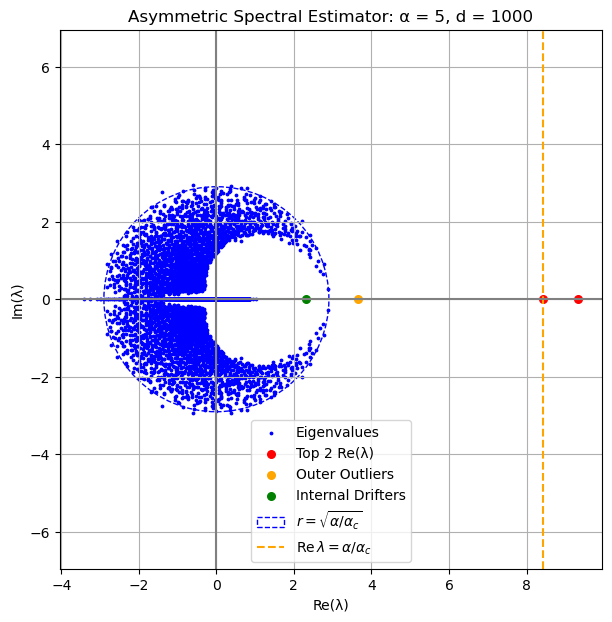


[Method 3: Single Eigenvector Alignment Scores]
  Eigenvalue  Index  Alignment Score
0     Green1   1086         0.026844
1    Orange1     33         0.019676
2       Red1      0         0.474070
3       Red2      1         0.452934

[Method 4: Eigenvector Pair Alignment Scores]
             Pair         Eigenvalue1         Eigenvalue2  Alignment Score
5       Red1-Red2  9.317551+0.000000j  8.425322+0.000000j         0.655660
1     Green1-Red1  2.314830+0.000000j  9.317551+0.000000j         0.474920
3    Orange1-Red1  3.663436+0.000000j  9.317551+0.000000j         0.474252
2     Green1-Red2  2.314830+0.000000j  8.425322+0.000000j         0.453729
4    Orange1-Red2  3.663436+0.000000j  8.425322+0.000000j         0.453362
0  Green1-Orange1  2.314830+0.000000j  3.663436+0.000000j         0.031354


/var/folders/kl/6hy0lk_14w14xqln8byr8l940000gn/T/ipykernel_25236/2143060237.py:292: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


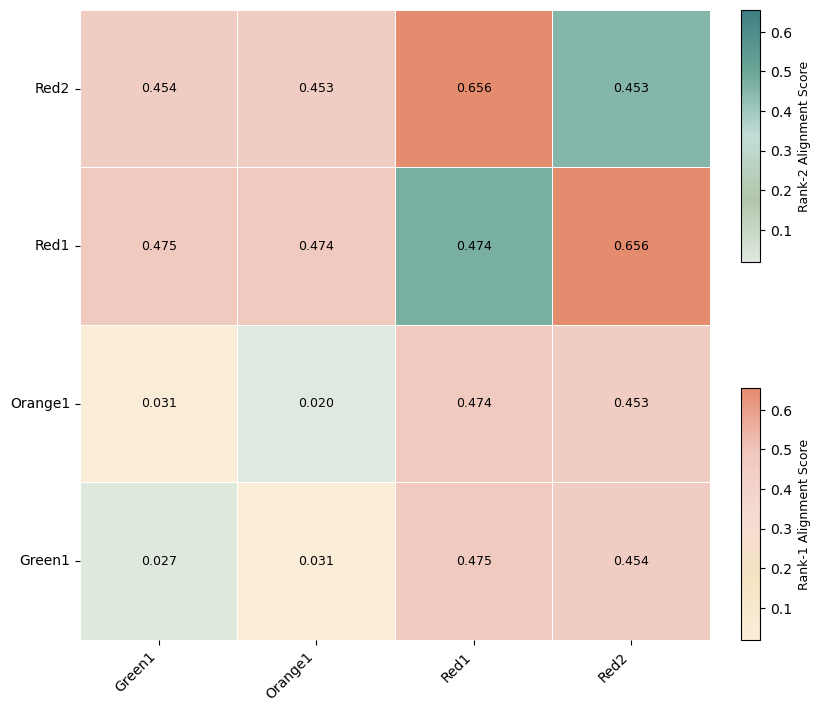

In [1]:
# asymmetric_spectral_estimator_updated.py

import os
import random
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import kv as besselk
from scipy.linalg import qr
from numpy.linalg import norm
from itertools import combinations
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ====================== 设置随机种子与设备 ======================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ====================== 参数设置与数据生成 ======================
n, p = 5000, 2
alpha = 5
alpha_c = 0.59375
d = int(n / alpha)
X = torch.randn(n, d, device=device) / np.sqrt(d)
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
y = Z[:, 0] * Z[:, 1]

# ====================== 构造 G(y) 与谱矩阵 L ======================
y_np = y.detach().cpu().numpy()
abs_y = np.abs(y_np)
K0, K1 = besselk(0, abs_y), besselk(1, abs_y)
lambda_y = abs_y * (K1 / (K0 + 1e-6)) - 1
lambda_y[np.isnan(lambda_y)] = 0

G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_np
G_y_np[:, 1, 0] = y_np
G_y = torch.tensor(G_y_np, device=device)

XXT = X @ X.T
XXT.fill_diagonal_(0.0)
L_blocks = XXT[:, :, None, None] * G_y[None, :, :, :]
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)
print(f"L shape: {L.shape}")

# ====================== 特征值与特征向量计算 ======================
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
eigvals_real_only = [z for z in eigvals_np if np.isclose(z.imag, 0.0, atol=1e-6)]

# ====================== 特征值分类 ======================
R = np.sqrt(alpha / alpha_c)
thresh = alpha / alpha_c

outside = [z for z in eigvals_real_only if abs(z) > R and z.real > 0]
red_vals = sorted(outside, key=lambda z: z.real, reverse=True)[:2]
orange_vals = [z for z in outside if z not in red_vals]
green_candidates = [z for z in eigvals_real_only if abs(z) <= R]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:1]

green_labels = [(f"Green{i+1}", z) for i, z in enumerate(green_vals)]
orange_labels = [(f"Orange{i+1}", z) for i, z in enumerate(orange_vals)]
red_labels = [(f"Red{i+1}", z) for i, z in enumerate(red_vals)]
all_labels = green_labels + orange_labels + red_labels
label_order = [label for label, _ in all_labels]

# ====================== 谱图绘制 ======================
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, s=3, color='blue', label='Eigenvalues')
plt.scatter([z.real for _, z in red_labels], [z.imag for _, z in red_labels], color='red', s=30, label="Top 2 Re(λ)")
plt.scatter([z.real for _, z in orange_labels], [z.imag for _, z in orange_labels], color='orange', s=30, label="Outer Outliers")
plt.scatter([z.real for _, z in green_labels], [z.imag for _, z in green_labels], color='green', s=30, label="Internal Drifters")
circle = plt.Circle((0, 0), R, color='blue', fill=False, linestyle='--', label=rf'$r = \sqrt{{\alpha / \alpha_c}}$')
plt.gca().add_artist(circle)
plt.axvline(x=thresh, color='orange', linestyle='--', label=rf'$\mathrm{{Re}}\,\lambda = \alpha / \alpha_c$')
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


# ====================== 评估函数（方法3与4） ======================
import numpy as np
import pandas as pd
from scipy.linalg import qr
from numpy.linalg import norm

def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

def map_multiple_eigvecs_to_2d(eigvecs_np, eigvals_np, selected_eigvals, X, W_star, eigval_to_label, p=2):
    """
    映射多个非对称谱估计器的特征向量到 2d 空间，计算每个单点的对齐度，并附带标签显示。

    参数:
        eigvecs_np: ndarray, shape (n*p, n*p) — 所有特征向量矩阵
        eigvals_np: ndarray, shape (n*p,) — 所有特征值列表
        selected_eigvals: list — 需要计算的特征值
        X: ndarray, shape (n, d) — 原始输入样本矩阵
        W_star: ndarray, shape (d, p) — 真实信号子空间矩阵
        eigval_to_label: dict — 特征值到标签的映射字典（如 "Red1", "Green2"）
        p: int — 信号子空间维度，默认2

    返回:
        pd.DataFrame — 包含标签、索引、对齐分数的结果表
    """
    n, d = X.shape
    results = []

    # 真实信号子空间映射成 (2d, p) 形状，方便对齐
    W_star_2d = np.vstack([W_star[:, i].reshape(-1,1) for i in range(p)])

    for val in selected_eigvals:
        idx = np.argmin(np.abs(eigvals_np - val))
        v = eigvecs_np[:, idx]  # shape (n*p,)
        V = v.reshape(n, p)      # reshape为 (n, p)

        if p == 1:
            mapped_vec = X.T @ V[:, 0]         # (d,)
            mapped_vec = mapped_vec.reshape(d, 1)
        elif p == 2:
            v0 = X.T @ V[:, 0]                 # (d,)
            v1 = X.T @ V[:, 1]                 # (d,)
            mapped_vec = np.vstack([v0.reshape(-1,1), v1.reshape(-1,1)])  # (2d, 1)
        else:
            raise NotImplementedError("目前只支持 p=1 或 p=2")

        eps = 1e-12
        mapped_vec /= (norm(mapped_vec, axis=0, keepdims=True) + eps)

        score = alignment_score(mapped_vec, W_star_2d)
        label = eigval_to_label.get(val, f"Unknown_{val}")
        results.append({"Eigenvalue": label, "Index": idx, "Alignment Score": score})

    return pd.DataFrame(results)


def joint_map_and_align(eigvecs_np, eigvals_np, pairs, X, W_star, p=2):
    """
    对每对特征值组合的特征向量进行联合映射并计算对齐分数。

    参数:
        eigvecs_np: ndarray, shape (np, np) 所有特征向量
        eigvals_np: ndarray, shape (np,) 所有特征值
        pairs: list of tuples, [(label1, eigval1, label2, eigval2), ...]
        X: ndarray, (n, d) 输入样本矩阵
        W_star: ndarray, (d, p) 真实信号子空间
        p: int, 子空间维度，默认2

    返回:
        pd.DataFrame，包含每对组合的对齐分数
    """

    n, d = X.shape
    results = []

    # 真实信号子空间映射到 2d 维（拼接p列）
    W_star_2d = np.vstack([W_star[:, i].reshape(-1, 1) for i in range(p)])  # (2d, p)

    for (label1, val1, label2, val2) in pairs:
        # 找特征向量索引
        idx1 = np.argmin(np.abs(eigvals_np - val1))
        idx2 = np.argmin(np.abs(eigvals_np - val2))

        # 取对应特征向量
        v1 = eigvecs_np[:, idx1]
        v2 = eigvecs_np[:, idx2]

        # reshape 成 (n, p)
        V1 = v1.reshape(n, p)
        V2 = v2.reshape(n, p)


        # 组合成 (n, p, 2)
        V_combined = np.stack([V1, V2], axis=2)  # shape (n, p, 2)

        # 投影回原空间，分别投影每个 p 维向量，拼接
        mapped_columns = []
        for pi in range(p):
            # X.T @ V_combined[:, pi, :] => (d, 2)
            mapped_columns.append(X.T @ V_combined[:, pi, :])  
        W_hat = np.vstack(mapped_columns)  # (2d, 2)

        # 归一化每列
        W_hat /= (norm(W_hat, axis=0, keepdims=True) + 1e-12)

        # QR + SVD 计算子空间对齐度
        Q1, _ = qr(W_hat, mode='economic')
        Q2, _ = qr(W_star_2d, mode='economic')
        overlap = Q1.T @ Q2
        _, s, _ = np.linalg.svd(overlap)
        score = np.mean(s)

        results.append({
            "Pair": f"{label1}-{label2}",
            "Eigenvalue1": val1,
            "Eigenvalue2": val2,
            "Alignment Score": score
        })

    return pd.DataFrame(results)

# ====================== 评估与热力图绘制 ======================
eigval_to_label = {val: label for label, val in all_labels}
selected_eigvals = list(eigval_to_label.keys())

df_single = map_multiple_eigvecs_to_2d(
    eigvecs_np, eigvals_np, selected_eigvals,
    X.cpu().numpy(), W_star.cpu().numpy(),
    eigval_to_label, p=2
)

all_pairs = list(combinations(all_labels, 2))
pairs = [(l1, v1, l2, v2) for (l1, v1), (l2, v2) in all_pairs]

df_pair = joint_map_and_align(
    eigvecs_np, eigvals_np, pairs,
    X.cpu().numpy(), W_star.cpu().numpy(), p=2
)

print("\n[Method 3: Single Eigenvector Alignment Scores]")
print(df_single)
print("\n[Method 4: Eigenvector Pair Alignment Scores]")
print(df_pair.sort_values(by="Alignment Score", ascending=False))

# ====================== 热力图 ======================
heatmap_df = pd.DataFrame(np.nan, index=label_order, columns=label_order)
for _, row in df_single.iterrows():
    heatmap_df.loc[row["Eigenvalue"], row["Eigenvalue"]] = row["Alignment Score"]
for _, row in df_pair.iterrows():
    a, b = row["Pair"].split("-")
    heatmap_df.loc[a, b] = heatmap_df.loc[b, a] = row["Alignment Score"]

diag_colors = ["#FAEED9", "#F5E3C2", "#F5DBD4", "#F0C7BC", "#E58B6E"]
offdiag_colors = ["#DFE9DF", "#B2C6AB", "#C2DED7", "#6DA798", "#3E7F84"]
diag_cmap = LinearSegmentedColormap.from_list("diag_cmap", diag_colors)
offdiag_cmap = LinearSegmentedColormap.from_list("offdiag_cmap", offdiag_colors)
mask_diag = pd.DataFrame(True, index=label_order, columns=label_order)
np.fill_diagonal(mask_diag.values, False)

fig, ax = plt.subplots(figsize=(8, 7))
vmin, vmax = np.nanmin(heatmap_df.values), np.nanmax(heatmap_df.values)
sns.heatmap(heatmap_df, mask=mask_diag, cmap=offdiag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)
cbar_ax1 = inset_axes(ax, width="3%", height="40%", loc='upper right',
                      bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
fig.colorbar(plt.cm.ScalarMappable(cmap=offdiag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax)),
             cax=cbar_ax1).set_label("Rank-2 Alignment Score", fontsize=9)

sns.heatmap(heatmap_df, mask=~mask_diag, cmap=diag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)
cbar_ax2 = inset_axes(ax, width="3%", height="40%", loc='lower right',
                      bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
fig.colorbar(plt.cm.ScalarMappable(cmap=diag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax)),
             cax=cbar_ax2).set_label("Rank-1 Alignment Score", fontsize=9)

for i in range(len(label_order)):
    for j in range(len(label_order)):
        val = heatmap_df.iloc[i, j]
        if not np.isnan(val):
            ax.text(j + 0.5, i + 0.5, f"{val:.3f}", ha='center', va='center', fontsize=9)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()
plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.90, top=0.95, bottom=0.05)
plt.show()


In [ ]:
# asymmetric_spectral_estimator_updated.py

import os
import random
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import kv as besselk
from scipy.linalg import qr
from numpy.linalg import norm
from itertools import combinations
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ====================== 设置随机种子与设备 ======================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ====================== 参数设置与数据生成 ======================
n, p = 5000, 2
alpha = 3
alpha_c = 0.59375
d = int(n / alpha)
X = torch.randn(n, d, device=device) / np.sqrt(d)
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
y = Z[:, 0] * Z[:, 1]

# ====================== 构造 G(y) 与谱矩阵 L ======================
y_np = y.detach().cpu().numpy()
abs_y = np.abs(y_np)
K0, K1 = besselk(0, abs_y), besselk(1, abs_y)
lambda_y = abs_y * (K1 / (K0 + 1e-6)) - 1
lambda_y[np.isnan(lambda_y)] = 0

G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_np
G_y_np[:, 1, 0] = y_np
G_y = torch.tensor(G_y_np, device=device)

XXT = X @ X.T
XXT.fill_diagonal_(0.0)
L_blocks = XXT[:, :, None, None] * G_y[None, :, :, :]
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)
print(f"L shape: {L.shape}")

# ====================== 特征值与特征向量计算 ======================
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
eigvals_real_only = [z for z in eigvals_np if np.isclose(z.imag, 0.0, atol=1e-6)]

# ====================== 特征值分类 ======================
R = np.sqrt(alpha / alpha_c)
thresh = alpha / alpha_c

outside = [z for z in eigvals_real_only if abs(z) > R and z.real > 0]
red_vals = sorted(outside, key=lambda z: z.real, reverse=True)[:2]
orange_vals = [z for z in outside if z not in red_vals]
green_candidates = [z for z in eigvals_real_only if abs(z) <= R]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:1]

green_labels = [(f"Green{i+1}", z) for i, z in enumerate(green_vals)]
orange_labels = [(f"Orange{i+1}", z) for i, z in enumerate(orange_vals)]
red_labels = [(f"Red{i+1}", z) for i, z in enumerate(red_vals)]
all_labels = green_labels + orange_labels + red_labels
label_order = [label for label, _ in all_labels]

# ====================== 谱图绘制 ======================
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, s=3, color='blue', label='Eigenvalues')
plt.scatter([z.real for _, z in red_labels], [z.imag for _, z in red_labels], color='red', s=30, label="Top 2 Re(λ)")
plt.scatter([z.real for _, z in orange_labels], [z.imag for _, z in orange_labels], color='orange', s=30, label="Outer Outliers")
plt.scatter([z.real for _, z in green_labels], [z.imag for _, z in green_labels], color='green', s=30, label="Internal Drifters")
circle = plt.Circle((0, 0), R, color='blue', fill=False, linestyle='--', label=rf'$r = \sqrt{{\alpha / \alpha_c}}$')
plt.gca().add_artist(circle)
plt.axvline(x=thresh, color='orange', linestyle='--', label=rf'$\mathrm{{Re}}\,\lambda = \alpha / \alpha_c$')
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


# ====================== 评估函数（方法3与4） ======================
import numpy as np
import pandas as pd
from scipy.linalg import qr
from numpy.linalg import norm

def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

def map_multiple_eigvecs_to_2d(eigvecs_np, eigvals_np, selected_eigvals, X, W_star, eigval_to_label, p=2):
    """
    映射多个非对称谱估计器的特征向量到 2d 空间，计算每个单点的对齐度，并附带标签显示。

    参数:
        eigvecs_np: ndarray, shape (n*p, n*p) — 所有特征向量矩阵
        eigvals_np: ndarray, shape (n*p,) — 所有特征值列表
        selected_eigvals: list — 需要计算的特征值
        X: ndarray, shape (n, d) — 原始输入样本矩阵
        W_star: ndarray, shape (d, p) — 真实信号子空间矩阵
        eigval_to_label: dict — 特征值到标签的映射字典（如 "Red1", "Green2"）
        p: int — 信号子空间维度，默认2

    返回:
        pd.DataFrame — 包含标签、索引、对齐分数的结果表
    """
    n, d = X.shape
    results = []

    # 真实信号子空间映射成 (2d, p) 形状，方便对齐
    W_star_2d = np.vstack([W_star[:, i].reshape(-1,1) for i in range(p)])

    for val in selected_eigvals:
        idx = np.argmin(np.abs(eigvals_np - val))
        v = eigvecs_np[:, idx]  # shape (n*p,)
        V = v.reshape(n, p)      # reshape为 (n, p)

        if p == 1:
            mapped_vec = X.T @ V[:, 0]         # (d,)
            mapped_vec = mapped_vec.reshape(d, 1)
        elif p == 2:
            v0 = X.T @ V[:, 0]                 # (d,)
            v1 = X.T @ V[:, 1]                 # (d,)
            mapped_vec = np.vstack([v0.reshape(-1,1), v1.reshape(-1,1)])  # (2d, 1)
        else:
            raise NotImplementedError("目前只支持 p=1 或 p=2")

        eps = 1e-12
        mapped_vec /= (norm(mapped_vec, axis=0, keepdims=True) + eps)

        score = alignment_score(mapped_vec, W_star_2d)
        label = eigval_to_label.get(val, f"Unknown_{val}")
        results.append({"Eigenvalue": label, "Index": idx, "Alignment Score": score})

    return pd.DataFrame(results)


def joint_map_and_align(eigvecs_np, eigvals_np, pairs, X, W_star, p=2):
    """
    对每对特征值组合的特征向量进行联合映射并计算对齐分数。

    参数:
        eigvecs_np: ndarray, shape (np, np) 所有特征向量
        eigvals_np: ndarray, shape (np,) 所有特征值
        pairs: list of tuples, [(label1, eigval1, label2, eigval2), ...]
        X: ndarray, (n, d) 输入样本矩阵
        W_star: ndarray, (d, p) 真实信号子空间
        p: int, 子空间维度，默认2

    返回:
        pd.DataFrame，包含每对组合的对齐分数
    """

    n, d = X.shape
    results = []

    # 真实信号子空间映射到 2d 维（拼接p列）
    W_star_2d = np.vstack([W_star[:, i].reshape(-1, 1) for i in range(p)])  # (2d, p)

    for (label1, val1, label2, val2) in pairs:
        # 找特征向量索引
        idx1 = np.argmin(np.abs(eigvals_np - val1))
        idx2 = np.argmin(np.abs(eigvals_np - val2))

        # 取对应特征向量
        v1 = eigvecs_np[:, idx1]
        v2 = eigvecs_np[:, idx2]

        # reshape 成 (n, p)
        V1 = v1.reshape(n, p)
        V2 = v2.reshape(n, p)


        # 组合成 (n, p, 2)
        V_combined = np.stack([V1, V2], axis=2)  # shape (n, p, 2)

        # 投影回原空间，分别投影每个 p 维向量，拼接
        mapped_columns = []
        for pi in range(p):
            # X.T @ V_combined[:, pi, :] => (d, 2)
            mapped_columns.append(X.T @ V_combined[:, pi, :])  
        W_hat = np.vstack(mapped_columns)  # (2d, 2)

        # 归一化每列
        W_hat /= (norm(W_hat, axis=0, keepdims=True) + 1e-12)

        # QR + SVD 计算子空间对齐度
        Q1, _ = qr(W_hat, mode='economic')
        Q2, _ = qr(W_star_2d, mode='economic')
        overlap = Q1.T @ Q2
        _, s, _ = np.linalg.svd(overlap)
        score = np.mean(s)

        results.append({
            "Pair": f"{label1}-{label2}",
            "Eigenvalue1": val1,
            "Eigenvalue2": val2,
            "Alignment Score": score
        })

    return pd.DataFrame(results)

# ====================== 评估与热力图绘制 ======================
eigval_to_label = {val: label for label, val in all_labels}
selected_eigvals = list(eigval_to_label.keys())

df_single = map_multiple_eigvecs_to_2d(
    eigvecs_np, eigvals_np, selected_eigvals,
    X.cpu().numpy(), W_star.cpu().numpy(),
    eigval_to_label, p=2
)

all_pairs = list(combinations(all_labels, 2))
pairs = [(l1, v1, l2, v2) for (l1, v1), (l2, v2) in all_pairs]

df_pair = joint_map_and_align(
    eigvecs_np, eigvals_np, pairs,
    X.cpu().numpy(), W_star.cpu().numpy(), p=2
)

print("\n[Method 3: Single Eigenvector Alignment Scores]")
print(df_single)
print("\n[Method 4: Eigenvector Pair Alignment Scores]")
print(df_pair.sort_values(by="Alignment Score", ascending=False))

# ====================== 热力图 ======================
heatmap_df = pd.DataFrame(np.nan, index=label_order, columns=label_order)
for _, row in df_single.iterrows():
    heatmap_df.loc[row["Eigenvalue"], row["Eigenvalue"]] = row["Alignment Score"]
for _, row in df_pair.iterrows():
    a, b = row["Pair"].split("-")
    heatmap_df.loc[a, b] = heatmap_df.loc[b, a] = row["Alignment Score"]

diag_colors = ["#FAEED9", "#F5E3C2", "#F5DBD4", "#F0C7BC", "#E58B6E"]
offdiag_colors = ["#DFE9DF", "#B2C6AB", "#C2DED7", "#6DA798", "#3E7F84"]
diag_cmap = LinearSegmentedColormap.from_list("diag_cmap", diag_colors)
offdiag_cmap = LinearSegmentedColormap.from_list("offdiag_cmap", offdiag_colors)
mask_diag = pd.DataFrame(True, index=label_order, columns=label_order)
np.fill_diagonal(mask_diag.values, False)

fig, ax = plt.subplots(figsize=(8, 7))
vmin, vmax = np.nanmin(heatmap_df.values), np.nanmax(heatmap_df.values)
sns.heatmap(heatmap_df, mask=mask_diag, cmap=offdiag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)
cbar_ax1 = inset_axes(ax, width="3%", height="40%", loc='upper right',
                      bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
fig.colorbar(plt.cm.ScalarMappable(cmap=offdiag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax)),
             cax=cbar_ax1).set_label("Rank-2 Alignment Score", fontsize=9)

sns.heatmap(heatmap_df, mask=~mask_diag, cmap=diag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)
cbar_ax2 = inset_axes(ax, width="3%", height="40%", loc='lower right',
                      bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
fig.colorbar(plt.cm.ScalarMappable(cmap=diag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax)),
             cax=cbar_ax2).set_label("Rank-1 Alignment Score", fontsize=9)

for i in range(len(label_order)):
    for j in range(len(label_order)):
        val = heatmap_df.iloc[i, j]
        if not np.isnan(val):
            ax.text(j + 0.5, i + 0.5, f"{val:.3f}", ha='center', va='center', fontsize=9)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()
plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.90, top=0.95, bottom=0.05)
plt.show()


In [ ]:
import torch, numpy as np, gc
from collections import defaultdict
from scipy.special import kv as besselk
from itertools import combinations
import pandas as pd

# ======= 参数配置 ========
n, p = 5000, 2
alpha, alpha_c = 5, 0.59375
d = int(n / alpha)
R = np.sqrt(alpha / alpha_c)
thresh = alpha / alpha_c
top_k = 5  # 控制绿点、橙点最多选取数量
num_trials = 10

# ======= 工具函数 ========
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

# ======= 对齐函数需提前定义 ========
def map_multiple_eigvecs_to_2d(eigvecs_np, eigvals_np, selected_eigvals, X, W_star, eigval_to_label, p=2):
    results = []
    W_star_2d = np.vstack([W_star[:, i].reshape(-1,1) for i in range(p)])
    for val in selected_eigvals:
        idx = np.argmin(np.abs(eigvals_np - val))
        v = eigvecs_np[:, idx]
        V = v.reshape(n, p)
        v0 = X.T @ V[:, 0]
        v1 = X.T @ V[:, 1]
        mapped_vec = np.vstack([v0.reshape(-1,1), v1.reshape(-1,1)])
        score = alignment_score(mapped_vec, W_star_2d)
        results.append({
            "Eigenvalue": eigval_to_label[val],
            "Alignment Score": score
        })
    return pd.DataFrame(results)

def joint_map_and_align(eigvecs_np, eigvals_np, label_val_pairs, X, W_star, p=2):
    results = []
    for l1, z1, l2, z2 in label_val_pairs:
        idx1 = np.argmin(np.abs(eigvals_np - z1))
        idx2 = np.argmin(np.abs(eigvals_np - z2))
        V = eigvecs_np[:, [idx1, idx2]].reshape(n, p, 2)

        # 只取第一个方向映射的两个向量
        mapped0 = X.T @ V[:, 0, 0]
        mapped1 = X.T @ V[:, 0, 1]
        V_2d = np.vstack([mapped0.reshape(-1, 1), mapped1.reshape(-1, 1)])  # shape: (2d, 1)

        W_star_2d = np.vstack([W_star[:, 0].reshape(-1,1), W_star[:, 1].reshape(-1,1)])  # shape: (2d, 1)

        score = alignment_score(V_2d, W_star_2d)
        results.append({
            "Pair": f"{l1} + {l2}",
            "Alignment Score": score
        })
    return pd.DataFrame(results)


def alignment_score(W_hat, W_star):
    Q1, _ = np.linalg.qr(W_hat)
    Q2, _ = np.linalg.qr(W_star)
    _, s, _ = np.linalg.svd(Q1.T @ Q2)
    return np.mean(s)

# ======= 记录器初始化 ========
spectral_tracker = defaultdict(list)
alignment_tracker_single = defaultdict(list)
alignment_tracker_pair = defaultdict(list)

# ======= 主循环 ========
for trial in range(num_trials):
    set_seed(trial)

    X = torch.randn(n, d) / np.sqrt(d)
    W_star = torch.randn(d, p)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]
    y_np = y.numpy()

    abs_y = np.abs(y_np)
    K0 = besselk(0, abs_y)
    K1 = besselk(1, abs_y)
    lambda_y = abs_y * (K1 / (K0 + 1e-6)) - 1
    lambda_y[np.isnan(lambda_y)] = 0

    G_y_np = np.zeros((n, p, p), dtype=np.float32)
    G_y_np[:, 0, 0] = lambda_y
    G_y_np[:, 1, 1] = lambda_y
    G_y_np[:, 0, 1] = y_np
    G_y_np[:, 1, 0] = y_np
    G_y = torch.tensor(G_y_np, device=X.device)

    XXT = X @ X.T
    XXT.fill_diagonal_(0.0)
    L_blocks = XXT[:, :, None, None] * G_y[None, :, :, :]
    L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)

    eigvals, eigvecs = torch.linalg.eig(L)
    eigvals_np = eigvals.cpu().numpy()
    eigvecs_np = eigvecs.cpu().numpy()

    # ==== 谱点分类 ====
    eigvals_real_only = [z for z in eigvals_np if np.isclose(z.imag, 0.0, atol=1e-6)]

    # 红点：最大实部前2个
    outside = [z for z in eigvals_real_only if abs(z) > R and z.real > 0]
    red_vals = sorted(outside, key=lambda z: z.real, reverse=True)[:2]

    # 橙点：跳出但非红点
    orange_vals = [z for z in outside if z not in red_vals][:top_k]

    # 绿点：谱半径内实轴点，按实部排序
    green_candidates = [z for z in eigvals_real_only if abs(z) <= R and np.isclose(z.imag, 0.0, atol=1e-6)]
    green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:top_k]

    # ==== 保存谱点 ====
    for i, z in enumerate(red_vals): spectral_tracker[f"Red{i+1}"].append(z)
    for i, z in enumerate(orange_vals): spectral_tracker[f"Orange{i+1}"].append(z)
    for i, z in enumerate(green_vals): spectral_tracker[f"Green{i+1}"].append(z)

    # ==== 记录对齐度 ====
    label_map = {}
    all_labels = []

    for i, z in enumerate(green_vals):
        label = f"Green{i+1}"; label_map[z] = label; all_labels.append((label, z))
    for i, z in enumerate(orange_vals):
        label = f"Orange{i+1}"; label_map[z] = label; all_labels.append((label, z))
    for i, z in enumerate(red_vals):
        label = f"Red{i+1}"; label_map[z] = label; all_labels.append((label, z))

    df_single = map_multiple_eigvecs_to_2d(
        eigvecs_np, eigvals_np, list(label_map.keys()),
        X.numpy(), W_star.numpy(), label_map, p=2
    )
    for _, row in df_single.iterrows():
        alignment_tracker_single[row["Eigenvalue"]].append(row["Alignment Score"])

    pairs = [(l1, v1, l2, v2) for (l1, v1), (l2, v2) in combinations(all_labels, 2)]
    df_pair = joint_map_and_align(
        eigvecs_np, eigvals_np, pairs,
        X.numpy(), W_star.numpy(), p=2
    )
    for _, row in df_pair.iterrows():
        alignment_tracker_pair[row["Pair"]].append(row["Alignment Score"])

    # ==== 清理内存 ====
    del X, W_star, Z, y, G_y, L, eigvals, eigvecs
    torch.cuda.empty_cache()
    gc.collect()

# ======= 汇总函数 ========
def summarize_complex_tracker(tracker):
    rows = []
    for label, values in tracker.items():
        vals = np.array(values)
        reals, imags = np.real(vals), np.imag(vals)
        rows.append({
            "Label": label,
            "Count": len(vals),
            "Mean Re": np.mean(reals),
            "Std Re": np.std(reals),
            "Mean Im": np.mean(imags),
            "Std Im": np.std(imags),
        })
    return pd.DataFrame(rows)

def summarize_alignment_tracker(tracker):
    rows = []
    for label, scores in tracker.items():
        rows.append({
            "Label": label,
            "Count": len(scores),
            "Mean Alignment": np.mean(scores),
            "Std Alignment": np.std(scores),
        })
    return pd.DataFrame(rows)

# ======= 输出统计表 ========
df_spectral_summary = summarize_complex_tracker(spectral_tracker)
df_align_single_summary = summarize_alignment_tracker(alignment_tracker_single)
df_align_pair_summary = summarize_alignment_tracker(alignment_tracker_pair)

# 打印结果
print("\n[谱点轨迹统计：每个点的复平面均值和标准差]")
print(df_spectral_summary)

print("\n[单点对齐度统计（方法3）]")
print(df_align_single_summary)

print("\n[双点组合对齐度统计（方法4）]")
print(df_align_pair_summary)
